<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Общий-комментарий" data-toc-modified-id="Общий-комментарий-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий комментарий</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

__________

Перед нами стоит задача построения модели машинного обучения, которая предсказывает количество заказов такси на следующий час. Основные требования к модели машинного обучения: точность предсказания(не более 48 по RMSE).

Для обучения предоставленны данные о заказах такси, зафиксированных с 1 марта 2018 года, по 31 августа 2018 года. Перед исследованием проведем подготовку предоставленных данных, проверим данные на пропуски, выбросы и проанализируем тренды и сезонные закономерности за текущий период.

Для иследования будем использовать 4 модели машинного обучения: LinearRegression, CatBoostRegressor, LightGBM Regressor и RandomForesRegressor. Для каждой модели подберем не менее трех гиперпараметров с помощью кроссвалидации через GridSearch. Обученные модели с подобранными гиперпараметры сравним между собой и с Dummy моделью.

Итогом исследования будет являться модель с наилучшими показателями точности предсказания.

## Подготовка

Подключим библиотеки необходимые в исследовании

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb


from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

Загрузим файл с данными.

In [2]:
file = '/datasets/taxi.csv'
try:
    data = pd.read_csv(file)
    print('Файл из директории', file, 'загружен')
except Exception as e:
    print('При загрузке файла', file, 'произошел сбой.\nОшибка:', e)

Файл из директории /datasets/taxi.csv загружен


In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В датафрейме 2 столбца: с датами и временем, и с колличеством заказов зафиксированных за текущий временной интервал

Столбец с датами необходимо преобразовать в формат DateTime и переиндексировать датафрейм полученными значениями. После преобразований проверить монотонность распределения даты и времени.

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.index.is_monotonic

True

В задаче поставлена цель прогнозирования колличества заказов на час, проведем ресемплирование данных просуммировав строки за один час.

In [8]:
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Итоговая выборка составляет 4416 строк и не имеет пропусков

## Анализ

Построим график за весь временной промежуток, без фильтров

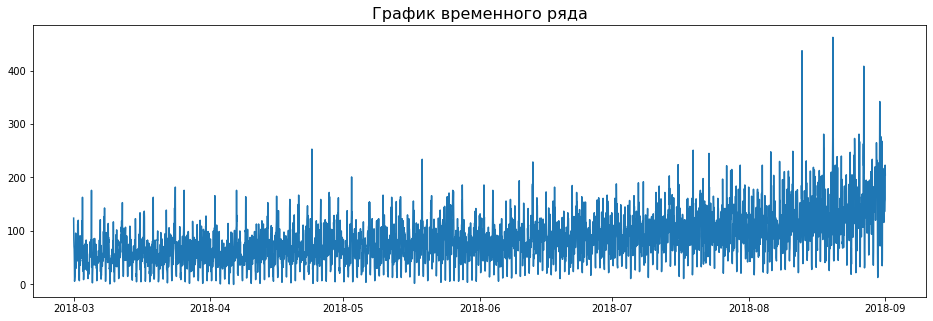

In [9]:
plt.figure(figsize=(16,5))
plt.title('График временного ряда', fontsize=16)
plt.plot(data.index, 'num_orders',data=data)
plt.show()

Из графика наблюдается восходящий тренд, проверим через скользящие средние

In [10]:
def moving_average(series, n):
    rolling_mean = series.rolling(window=n).mean()
    plt.figure(figsize=(16,5))
    plt.title("Скользящее среднее\n Размер окна = {}".format(n))
    plt.plot(rolling_mean, label="Rolling mean trend")

Построим график скользящей средней с суточным окном(24 строки)

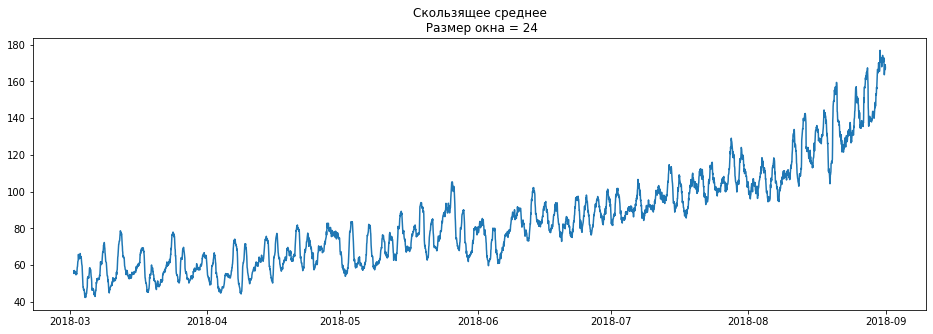

In [11]:
moving_average(data['num_orders'], 24)

Построим график скользящей средней с недельным окном(24 строки*7)

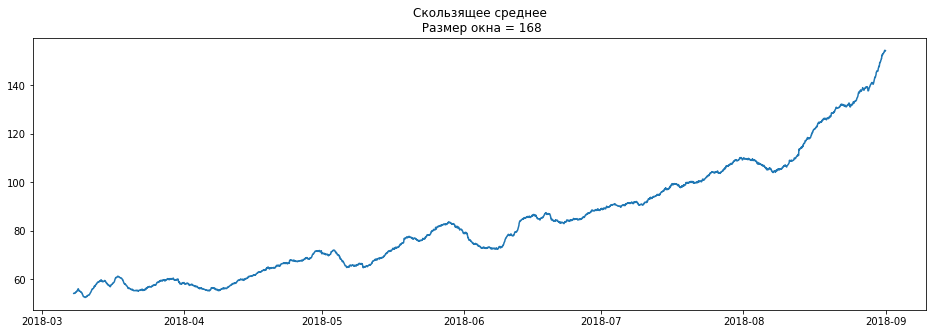

In [12]:
moving_average(data['num_orders'], 24*7)

На графике с недельным окном явно виден восходщий тренд и месячная сезонность. У месячной сезонности наблюдается спид колличества заказов с начала месяца вплоть до первой декады, а затем рост до конца месяца с перекрытием пика предыдущего. Необходимо исследовать недельную и суточную сезонность.

Данные предоставленны с начала весны, по конец лета, данный промежуток времени может мыть частью годовой сезонности, по предположению выглядящей как рост заказов  до конца лета и снижение заказов до конца зимы.

In [13]:
def season_plot(data, resample, rolling):
    season_plot = data.resample(resample).sum()
    season_plot['std'] = season_plot['num_orders'].rolling(rolling).std()
    season_plot.plot(figsize=(16,5), title = 'График временного ряда {}:{}'.format(season_plot.index.date.min(), season_plot.index.date.max()));
    plt.grid(which='major', 
        color = 'k', 
        linewidth = 1)
    plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
    plt.show()
    return

Построим часовые графики графики для одного случайного дня, для двух и трех последовательных дней

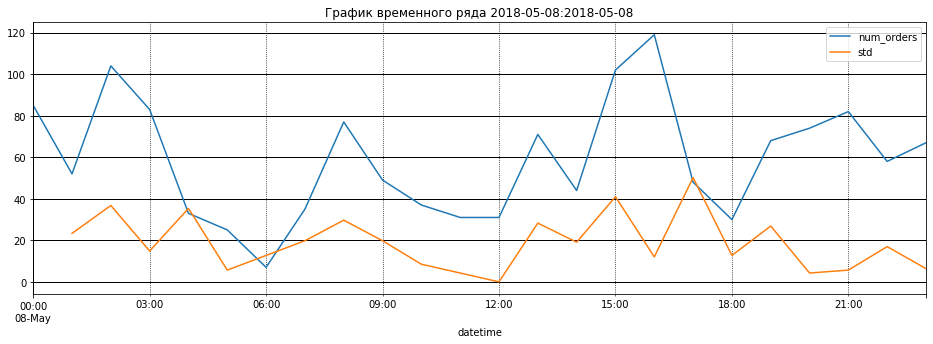

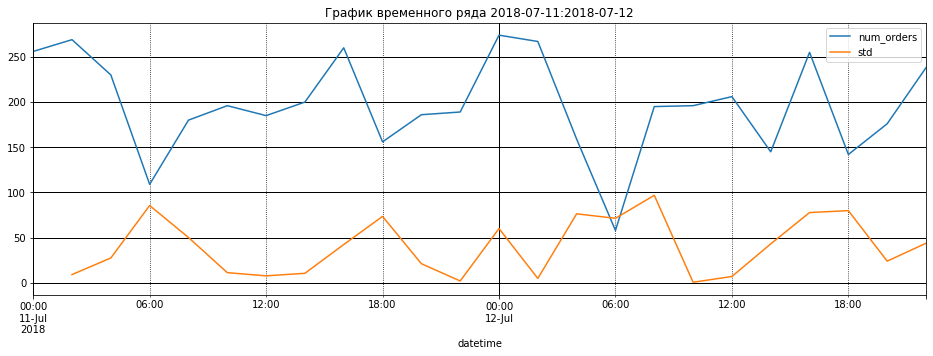

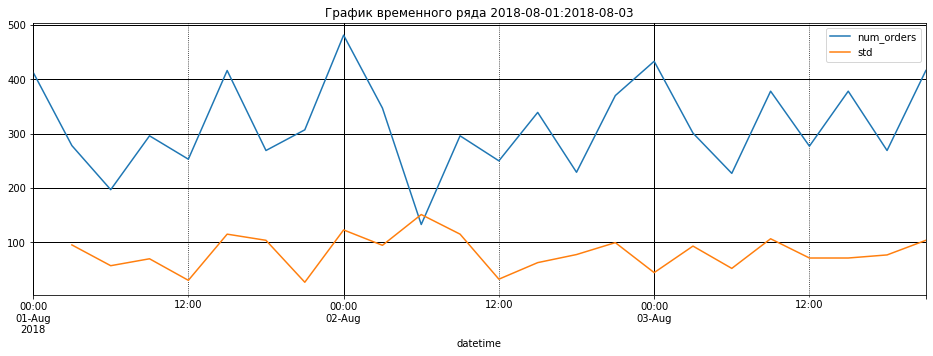

In [14]:
season_plot(data['2018-05-08':'2018-05-08'], '1H', 2);
season_plot(data['2018-07-11':'2018-07-12'], '2H', 2);
season_plot(data['2018-08-01':'2018-08-03'], '3H', 2);

Четко прослеживается сезонность среди дня, в 6 утра минимальное колличество заказов, далее повышающиеся пики загруженности идут с 8 до 10(начало рабочего времени), с 12 до 14(обеденное время), с 16 до 18(окончание рабочего дня) и самый высокий пик в районе полуночи.

Возьмем месячный промежуток. Начало графика выставим на понедельник и попробуем отследить недельную сезонность

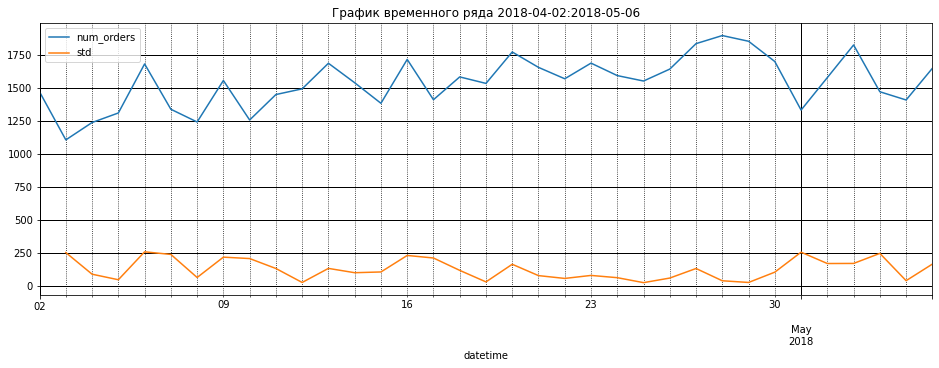

In [15]:
season_plot(data['2018-04-02':'2018-05-6'], '1D', 2)

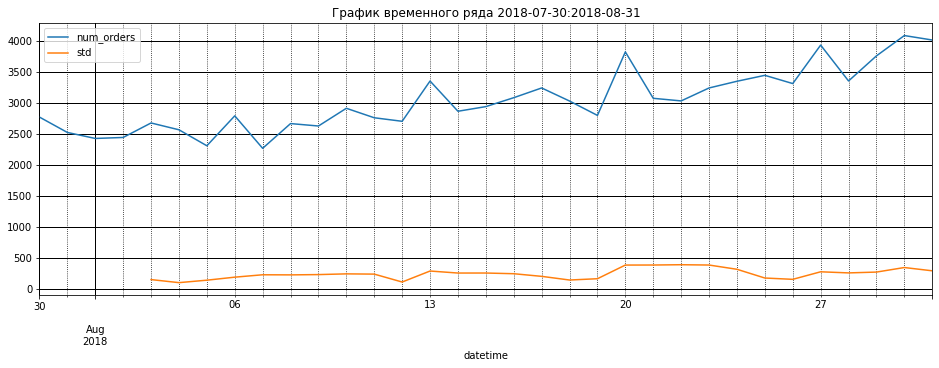

In [16]:
season_plot(data['2018-07-30':'2018-08-31'], '1D', 5)

Наблюдются максимальные всплески в понедельник и пятницу, минимальные впадины приходятся на вторник и воскресение.

Необходимо создание новых признаков для учета сезонности: - день - месяц - день недели - утро - начало рабочего дня - обед - конец рабочего дня - начало/конец рабочей недели - середина рабочей недели - выходные

## Обучение

Зададим максимальное значение для отстающих значений и окно для скользящей средней

In [17]:
max_lag = 100
rolling_mean_size = 48

Создаем функцию для расчета корня из среднеквадратичной ошибки и собственную метрику для кросс-валидации

In [18]:
def root_mean_squared_error(target, predict):
    return np.sqrt(mean_squared_error(target, predict))

RMSE = make_scorer(root_mean_squared_error, greater_is_better = False)

Создаем признаки

In [19]:
def features_from_datetime(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour
    data['is_weekend'] = data.weekday.isin([5,6])*1
    data['is_start_end_workweek'] = data.weekday.isin([0,4])*1
    data['is_midl_workweek'] = data.weekday.isin([1,2,3])*1
    data['is_morning'] = data.hour.isin(range(5,7))*1
    data['is_start_work'] = data.hour.isin(range(8,10))*1
    data['is_dinner'] = data.hour.isin(range(12,14))*1
    data['is_end_work'] = data.hour.isin(range(16,18))*1
    data['is_evening'] = data.hour.isin(range(20,23))*1

    for lag in range(1, max_lag + 1):
        data = pd.concat([data, data['num_orders'].shift(100).rename('lag_{}'.format(lag))], axis=1)

    data = pd.concat([data, data['num_orders'].shift().rolling(rolling_mean_size).mean().rename('rolling_mean')], axis=1)
    
    data = data.dropna()
    return data

In [20]:
data = features_from_datetime(data, max_lag, rolling_mean_size)

Делим выборку на обучающую и тестовую

In [21]:
features = data.drop(['num_orders'], axis = 1)
target = data['num_orders']
    
features_train, features_test, target_train, target_test = train_test_split(features,  target, 
                                                                            shuffle=False, test_size=0.1)

Обучаем модели по умолчанию

In [22]:
model_linear = LinearRegression(n_jobs=-1)
model_linear.fit(features_train, target_train)
model_linear_predict = model_linear.predict(features_train)
print('RMSE:', root_mean_squared_error(target_train, model_linear_predict))

RMSE: 29.550428933713146


In [23]:
model_forest = RandomForestRegressor(random_state=12345, n_jobs=-1)
model_forest.fit(features_train, target_train)
model_forest_predict = model_forest.predict(features_train)
print('RMSE:', root_mean_squared_error(target_train, model_forest_predict))

RMSE: 8.116602944419762


In [24]:
model_cat = CatBoostRegressor(random_state=12345, verbose=0)
model_cat.fit(features_train, target_train)
model_cat_predict = model_cat.predict(features_train)
print('RMSE:', root_mean_squared_error(target_train, model_cat_predict))

RMSE: 14.557011627766729


In [25]:
model_lgb = lgb.LGBMRegressor(random_state=12345, n_jobs=-1, num_threads=8)
model_lgb.fit(features_train, target_train)
model_lgb_predict = model_lgb.predict(features_train)
print('RMSE:', root_mean_squared_error(target_train, model_lgb_predict))

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
RMSE: 15.94513393290097


Задаем сетку параметров для GridSearch

In [26]:
parameters_rfr ={
    'n_estimators': range (100, 150, 25),
    'max_depth': range (10, 30, 10),
    'min_samples_split':range(2, 3, 1),
    'min_samples_leaf':range(1, 3, 1)
}

In [27]:
parameters_cat ={
    'iterations': range (1000, 1200, 100),
    'depth': range (6, 8),
    'min_data_in_leaf':range(1, 3, 1)
}

In [28]:
parameters_lgb ={
    'n_estimators':range (100, 150, 25),
    'num_leaves': [10, 30, 10],
    'max_depth':[10, 30, 1]
}

Делим выборки для кросс-валидации через TimeSeriesSplit

In [29]:
cv_split = TimeSeriesSplit(n_splits=5).split(features_train)

Подбираем лучшие параметры через GridSearch

In [30]:
grid_rfr = GridSearchCV(model_forest, parameters_rfr, cv=cv_split, scoring=RMSE, n_jobs=-1, refit=True)
grid_rfr.fit(features_train, target_train)
display(grid_rfr.best_params_)

#{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 125}

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 125}

In [31]:
model_forest = grid_rfr.best_estimator_

In [32]:
cv_split = TimeSeriesSplit(n_splits=5).split(features_train)

In [33]:
grid_cat = GridSearchCV(model_cat, parameters_cat, cv=cv_split, scoring=RMSE, n_jobs=-1, refit=True)
grid_cat.fit(features_train, target_train)
display(grid_cat.best_params_)

#{'depth': 6, 'iterations': 1100, 'min_data_in_leaf': 1}

{'depth': 7, 'iterations': 1000, 'min_data_in_leaf': 1}

In [34]:
model_cat = grid_cat.best_estimator_

In [35]:
model_cat.get_params()

{'iterations': 1000,
 'depth': 7,
 'loss_function': 'RMSE',
 'verbose': 0,
 'random_state': 12345,
 'min_data_in_leaf': 1}

In [36]:
cv_split = TimeSeriesSplit(n_splits=5).split(features_train)

In [37]:
grid_lgb = GridSearchCV(model_lgb, parameters_lgb, cv=cv_split, scoring=RMSE, verbose=False, refit=True)

grid_lgb.fit(features_train, target_train)

print(grid_lgb.best_params_)

#{'max_depth': 100, 'n_estimators': 125, 'num_leaves': 10}

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM]

In [38]:
model_lgb = grid_lgb.best_estimator_

In [39]:
model_lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 10,
 'objective': None,
 'random_state': 12345,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'num_threads': 8}

In [43]:
model_dummy = DummyRegressor()

Проводим кросс-валидацию на тестовой выборке и выбираем лучшую модель с самой низкой оценкой RMSE

In [44]:
def model_ef (model, cv, target, feaches):
    cv_split = TimeSeriesSplit(n_splits=cv).split(features_train)
    cv_results = cross_validate(model, feaches, target, cv=cv_split, scoring=RMSE, return_estimator=True)
    return cv_results

In [45]:
cv_results = []
models = [model_forest, model_cat, model_lgb, model_linear, model_dummy]
for i in models:
    
    res = model_ef(i, 5, target_train, features_train)
    cv_results.append(abs(res['test_score'].mean()))
cv_results = pd.DataFrame(cv_results, columns=['RMSE'], index=['RandomForest', 'CatBoost', 'LightGBM', 'LinearRegression', 'Dummy'])
cv_results.sort_values(by='RMSE', ascending=True)

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8


,RMSE
RandomForest,25.766337
LightGBM,25.796401
CatBoost,27.373561
LinearRegression,31.882677
Dummy,40.622251


## Тестирование

Проведем тестирование лучшей модели на тестовой выборке.

In [46]:
model_lgb.fit(features_train, target_train)
model_lgb_predict = model_lgb.predict(features_test)
print('RMSE:', root_mean_squared_error(target_test, model_lgb_predict))

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
RMSE: 44.782507536892545


In [47]:
predictions = pd.DataFrame(model_lgb_predict)
predictions.index = target_test.index
predictions_concat = pd.concat([predictions, target_test], axis=1)
predictions_concat.columns=['predictions', 'target']

Построим график заказов для тестовой выборки и предсказаний 

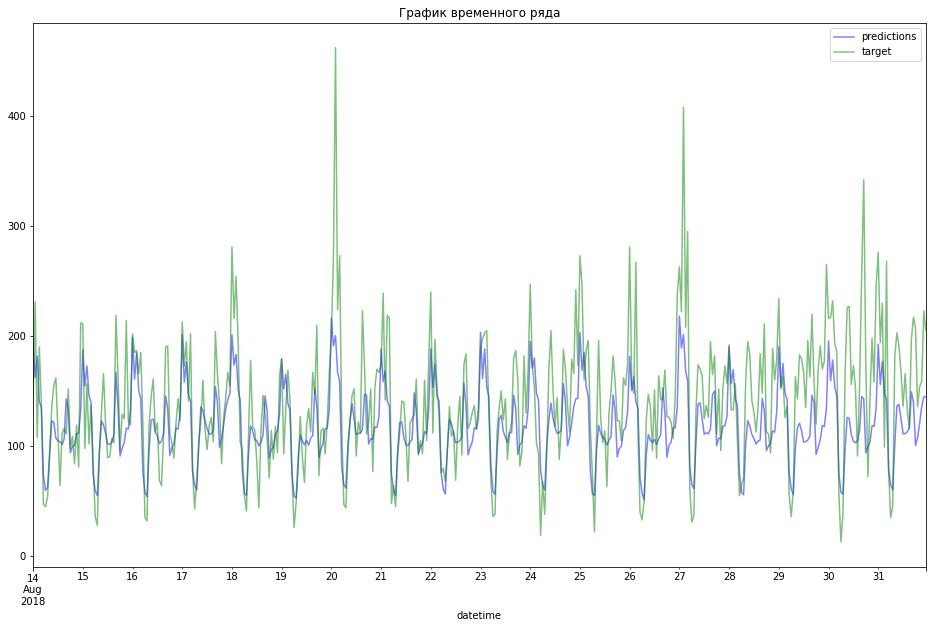

In [48]:
predictions_concat.plot(figsize=(16,10), title = 'График временного ряда', color=['Blue', 'Green'], alpha=0.5);

## Вывод

В текущей работе были исследованны данные о колличестве заказов такси за период 1 марта 2018 по 31 августа 2018. Результатом исследования является модель с наилучшим показателем RMSE предсказания.

Перед обучением проведен анализ сезонности и тренда заказов. Это позволило определить список признаков необходимых для обучения модели.

Были обучены 4 разных модели обучения, предсказывающие цену подержанного автомобиля: LinearRegression, RandomForestRegressor, LightGBM Regressor и CatBoostRegressor. LinearRegression показала самый худший показатель RMSE в 31.8. RandomForestRegressor обучился с лучшим показателем RMSE в 25.76. А LightGBM Regressor показал очень близкие результаты RMSE с отличием в 0.03, итоговая оценка 25.79. CatBoostRegressor показал результат на уровне 27.3

Для проверки результатов проведено сравнение с константной моделью, которая дала показатель в 40.1, что так же меньше требуемого порога установленного для задачи.

Лучшей моделью выберем LightGBM Regressor, RMSE для которой удалось уменьшить за счет подбора гиперпараметров до показателя 23.62 и скорость работы которой выше чем RandomForestRegressor.

На тестовой выборке LightGBM Regressor показал значение RMSE в 44.8 что проходит порог установленный для задачи.